## Environment & Dependencies

This notebook is designed to be run in a Python 3 environment and focuses on PyTorch for linear regression.

**OS & GPU Context:**
While this example can run on various operating systems, this notebook was created with **Ubuntu 22.04** and an **NVIDIA RTX 3090 (24GB VRAM)** in mind. For PyTorch, having a compatible NVIDIA GPU and the necessary CUDA drivers installed will allow for GPU acceleration, which can significantly speed up training for larger models. However, this specific example is small enough to run efficiently on a CPU as well.

**Installation:**
You can install the necessary libraries using pip. Open your terminal or command prompt and run:
```bash
pip install torch torchvision torchaudio numpy matplotlib
```
*(Note: `matplotlib` is added for potential visualizations, though not strictly required by the base examples.)*

Ensure your Python environment is set up correctly before proceeding. For GPU support with PyTorch, you might need to install specific versions compatible with your CUDA toolkit. Please refer to PyTorch's official installation guide for detailed instructions.

## Checking GPU Availability Using PyTorch

### PyTorch Test
#### Output should look like:
```bash
PyTorch CUDA version: 12.6
PyTorch cuDNN version: 90800
Number of GPUs available: 2
GPU Name: NVIDIA GeForce RTX 3090
```

In [1]:
import torch

if torch.cuda.is_available():
    print(f"PyTorch CUDA version: {torch.version.cuda}")
    # You can also check the cudnn version PyTorch is linked with
    print(f"PyTorch cuDNN version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}") # Gets name of first GPU
else:
    print("PyTorch: CUDA is not available.")

PyTorch CUDA version: 12.6
PyTorch cuDNN version: 90800
Number of GPUs available: 2
GPU Name: NVIDIA GeForce RTX 3090


## 1. PyTorch: Simple Linear Regression

This example demonstrates how to build a basic linear regression model using PyTorch. Linear regression is a fundamental algorithm in machine learning used to model the linear relationship between a dependent variable (y) and one or more independent variables (x). Our goal is to predict `y = 2x + 1` based on some generated data with a bit of noise.

### 1.1 Importing Libraries

First, we import the necessary libraries:
-   `torch`: The main PyTorch library.
-   `torch.nn`: A submodule in PyTorch that contains building blocks for creating neural networks (like layers, loss functions, etc.). `nn` stands for Neural Network.
-   `numpy`: A popular library for numerical computations in Python, often used for creating and manipulating arrays (which we'll convert to PyTorch tensors).

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt # For plotting

### 1.2 Generating Synthetic Data

We need data to train our model. Since we want to model `y = 2x + 1`, we'll generate some `x` values and calculate the corresponding `y` values, adding a small amount of random noise to make it more realistic.

-   `np.linspace(0, 10, 100)`: Creates 100 evenly spaced numbers between 0 and 10. This will be our `x`.
-   `.reshape(-1, 1)`: Changes the shape of `x` to be a 2D array with 100 rows and 1 column. PyTorch models usually expect inputs in this format.
-   `astype(np.float32)`: Converts the data type to 32-bit floating point numbers, which is standard for PyTorch tensors.
-   `y = 2 * x + 1 + np.random.normal(0, 0.1, x.shape)`: Calculates `y` using our linear equation and adds some Gaussian noise (mean 0, standard deviation 0.1).

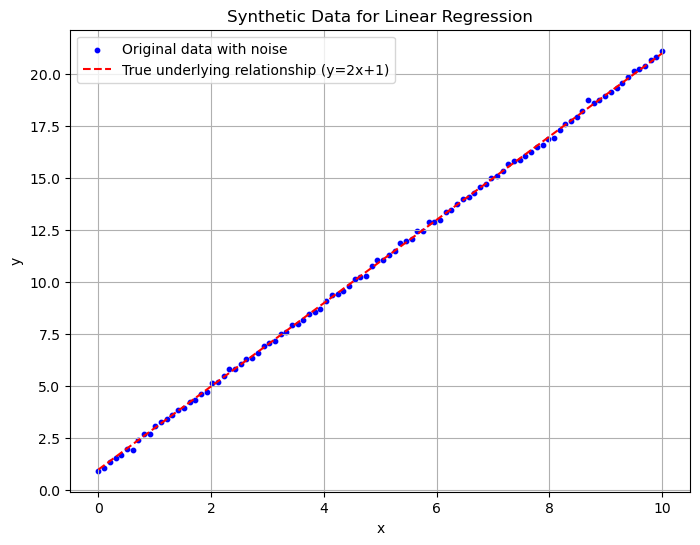

In [3]:
# Generate synthetic data
x_numpy = np.linspace(0, 10, 100).reshape(-1, 1).astype(np.float32)
y_numpy = 2 * x_numpy + 1 + np.random.normal(0, 0.1, x_numpy.shape).astype(np.float32)

# Let's visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(x_numpy, y_numpy, label='Original data with noise', color='blue', s=10) # s is marker size
plt.plot(x_numpy, 2 * x_numpy + 1, label='True underlying relationship (y=2x+1)', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data for Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

### 1.3 Converting Data to PyTorch Tensors

PyTorch models operate on tensors, enabling automatic differentiation and seamless GPU acceleration. We convert our NumPy arrays to tensors:

1. **Wrap Arrays** – `torch.from_numpy(x_numpy)` and `torch.from_numpy(y_numpy)` turn NumPy arrays into `torch.Tensor` objects with shared memory (no copy).  
2. **Data Type** – Ensure values are `float32`, the standard for PyTorch operations and GPU compatibility.  
3. **Shape Alignment** – Confirm tensor shapes match the model’s expected input dimensions.  
4. **Device Placement** – Move tensors to GPU if available via `tensor.to(device)` or `tensor.cuda()`.

In [4]:
# Convert to PyTorch tensors
x_tensor = torch.from_numpy(x_numpy)
y_tensor = torch.from_numpy(y_numpy)

print(f"Shape of x_tensor: {x_tensor.shape}")
print(f"Shape of y_tensor: {y_tensor.shape}")

Shape of x_tensor: torch.Size([100, 1])
Shape of y_tensor: torch.Size([100, 1])


### 1.4 Defining the Linear Regression Model

We define our model as a Python class that inherits from `nn.Module`. This is the standard way to create models in PyTorch.

-   `__init__(self)`: The constructor. Here, we define the layers of our model. 
    -   `super(LinearRegression, self).__init__()`: Calls the constructor of the parent class (`nn.Module`). This is necessary.
    -   `self.linear = nn.Linear(1, 1)`: This creates a linear layer. 
        -   The first `1` means the input to this layer has 1 feature (our `x` value).
        -   The second `1` means the output of this layer has 1 feature (our predicted `y` value).
        -   This layer will learn a weight (slope) and a bias (intercept) for the equation `y = weight * x + bias`.
-   `forward(self, x)`: This method defines how the input `x` flows through the model to produce an output. Here, it simply passes `x` through our linear layer.

In [5]:
# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        # Input features: 1 (x), Output features: 1 (y_predicted)
        self.linear = nn.Linear(in_features=1, out_features=1)
      
    def forward(self, x):
        # This defines the computation performed at every call.
        return self.linear(x)

### 1.5 Initializing Model, Loss Function, and Optimizer

-   **Model**: `model = LinearRegressionModel()`: We create an instance of our model class.
-   **Loss Function**: `criterion = nn.MSELoss()`: The loss function measures how different our model's predictions are from the actual `y` values. 
    -   `MSELoss` stands for Mean Squared Error. It calculates the average of the squares of the differences between predictions and actual values. This is a common loss function for regression tasks.
-   **Optimizer**: `optimizer = torch.optim.SGD(model.parameters(), lr=0.01)`: The optimizer is responsible for updating the model's parameters (weights and biases) to minimize the loss.
    -   `torch.optim.SGD`: Stochastic Gradient Descent. A common optimization algorithm.
    -   `model.parameters()`: Tells the optimizer which parameters (weights and biases of our `self.linear` layer) it needs to update.
    -   `lr=0.01`: Learning rate. This controls how big the steps are when updating parameters. A smaller learning rate means smaller steps and potentially longer training, but can be more stable. A larger learning rate can speed up training but might overshoot the optimal values.

In [6]:
# Initialize model, loss function, and optimizer
model = LinearRegressionModel()
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Stochastic Gradient Descent

### 1.6 Training Loop

This is where the model learns. We repeat the process for a certain number of `epochs`. An epoch is one complete pass through the entire training dataset.

Inside the loop:
1.  `y_pred = model(x_tensor)`: Forward pass. Get predictions from the model using the current `x_tensor`.
2.  `loss = criterion(y_pred, y_tensor)`: Calculate the loss by comparing the predictions (`y_pred`) with the actual values (`y_tensor`).
3.  `optimizer.zero_grad()`: Clear old gradients. Gradients are values that indicate the direction to adjust parameters to reduce loss. We need to clear them before calculating new ones for the current step, otherwise they accumulate.
4.  `loss.backward()`: Backward pass. Calculate the gradients of the loss with respect to the model's parameters. This is where PyTorch's automatic differentiation (autograd) shines.
5.  `optimizer.step()`: Update parameters. The optimizer adjusts the model's parameters using the calculated gradients and the learning rate.
6.  `if epoch % 20 == 0:`: Print the loss every 20 epochs to monitor training progress.

In [7]:
# Training loop
epochs = 100
losses = []  # Initialize list to store loss values for plotting

for epoch in range(epochs):
    # 1. Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_tensor)
    
    # 2. Compute loss
    loss = criterion(y_pred, y_tensor)
    losses.append(loss.item()) # .item() gets the scalar value of the loss
    
    # 3. Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()  # Clears existing gradients
    loss.backward()      # Computes gradients of the loss w.r.t. parameters
    optimizer.step()       # Updates parameters based on gradients
      
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [20/100], Loss: 0.0572
Epoch [40/100], Loss: 0.0485
Epoch [60/100], Loss: 0.0414
Epoch [80/100], Loss: 0.0355
Epoch [100/100], Loss: 0.0307


### 1.7 Print Learned Parameters and Visualize Results

After training, our model's `linear` layer has learned a weight (slope) and a bias (intercept). We expect these to be close to 2 and 1, respectively, since our original data was generated from `y = 2x + 1`.

-   `model.linear.weight.item()`: Gets the learned weight (slope).
-   `model.linear.bias.item()`: Gets the learned bias (intercept).

We also plot the original data, the true line, and the line our model learned.


Learned equation: y = 2.0496x + 0.6761


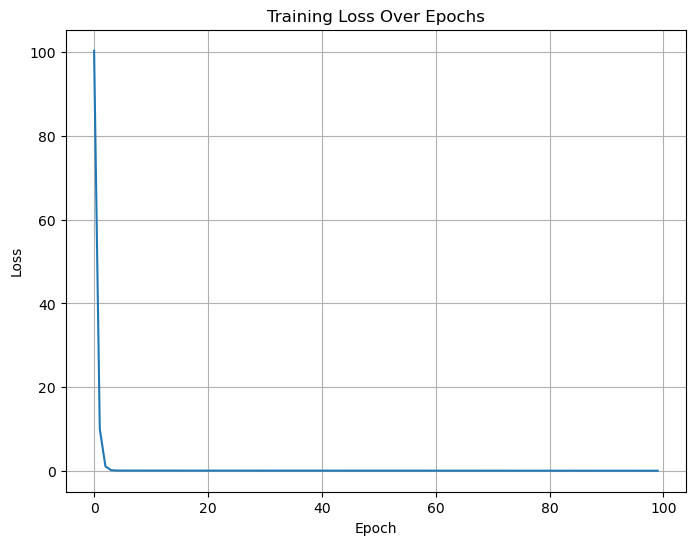

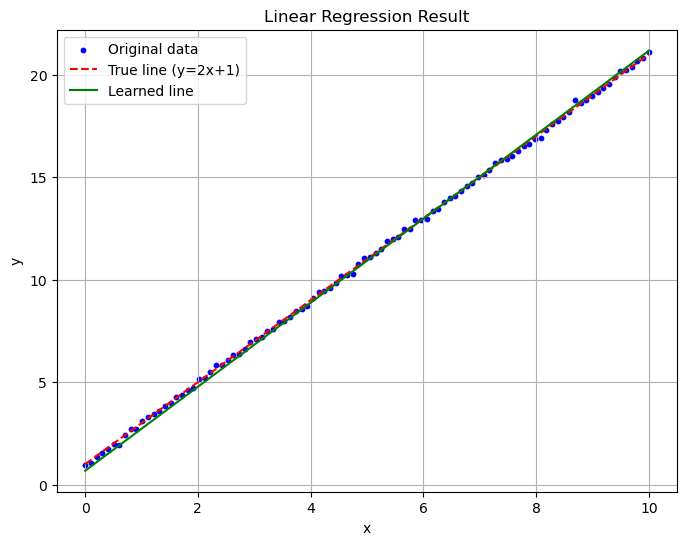

In [8]:
# Print learned parameters
learned_weight = model.linear.weight.item()
learned_bias = model.linear.bias.item()
print(f"\nLearned equation: y = {learned_weight:.4f}x + {learned_bias:.4f}")

# Plot the training loss
plt.figure(figsize=(8,6))
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

# Visualize the learned line
model.eval() # Set the model to evaluation mode (important for some layers like dropout, batchnorm)
with torch.no_grad(): # Disable gradient calculation for inference
    predicted_line = model(x_tensor).detach().numpy() # Get predictions and convert to numpy

plt.figure(figsize=(8, 6))
plt.scatter(x_numpy, y_numpy, label='Original data', color='blue', s=10)
plt.plot(x_numpy, 2 * x_numpy + 1, label='True line (y=2x+1)', color='red', linestyle='--')
plt.plot(x_numpy, predicted_line, label='Learned line', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression Result')
plt.legend()
plt.grid(True)
plt.show()

### 1.8 PyTorch Practice Variation: Different Optimizer and Loss Function

The original example uses Stochastic Gradient Descent (`SGD`) as the optimizer and Mean Squared Error (`MSELoss`) as the loss function. Let's try changing these:

-   **Optimizer**: We can use `Adam` (Adaptive Moment Estimation), which is often a good default optimizer and can converge faster or achieve better results than SGD for some problems. It adapts the learning rate for each parameter.
-   **Loss Function**: We can use `L1Loss` (Mean Absolute Error or MAE). Instead of squaring the differences between predicted and actual values, `L1Loss` takes the absolute difference. This can make the model less sensitive to outliers compared to `MSELoss`.

We'll repeat the process with these changes.

Training with Adam optimizer and L1Loss:

Epoch [20/100], Loss (L1): 7.8924
Epoch [40/100], Loss (L1): 6.6924
Epoch [60/100], Loss (L1): 5.4924
Epoch [80/100], Loss (L1): 4.2924
Epoch [100/100], Loss (L1): 3.0924

Learned equation (variation): y = 1.4602x + 0.6628


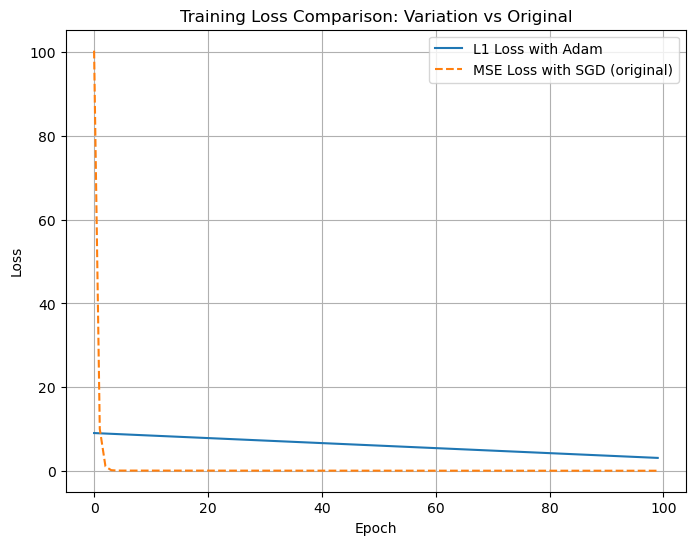

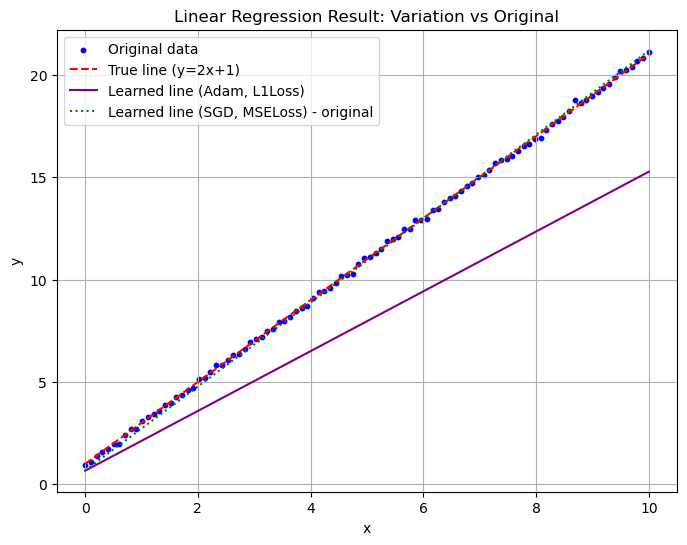

In [9]:
# Re-initialize model (to reset learned parameters)
model_variation = LinearRegressionModel()

# Variation: Use Adam optimizer and L1Loss
criterion_variation = nn.L1Loss()  # Mean Absolute Error
optimizer_variation = torch.optim.Adam(model_variation.parameters(), lr=0.01) # Adam optimizer

print("Training with Adam optimizer and L1Loss:\n")
losses_variation = []

# Training loop for the variation
for epoch in range(epochs): # Using the same number of epochs
    y_pred_variation = model_variation(x_tensor)
    loss_variation = criterion_variation(y_pred_variation, y_tensor)
    losses_variation.append(loss_variation.item())
    
    optimizer_variation.zero_grad()
    loss_variation.backward()
    optimizer_variation.step()
      
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss (L1): {loss_variation.item():.4f}")

# Print learned parameters for the variation
learned_weight_var = model_variation.linear.weight.item()
learned_bias_var = model_variation.linear.bias.item()
print(f"\nLearned equation (variation): y = {learned_weight_var:.4f}x + {learned_bias_var:.4f}")

# Plot the training loss for the variation
plt.figure(figsize=(8,6))
plt.plot(range(epochs), losses_variation, label='L1 Loss with Adam')
plt.plot(range(epochs), losses, label='MSE Loss with SGD (original)', linestyle='--') # Plot original for comparison
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: Variation vs Original')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the learned line for the variation
model_variation.eval()
with torch.no_grad():
    predicted_line_var = model_variation(x_tensor).detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(x_numpy, y_numpy, label='Original data', color='blue', s=10)
plt.plot(x_numpy, 2 * x_numpy + 1, label='True line (y=2x+1)', color='red', linestyle='--')
plt.plot(x_numpy, predicted_line_var, label='Learned line (Adam, L1Loss)', color='purple')
plt.plot(x_numpy, predicted_line, label='Learned line (SGD, MSELoss) - original', color='green', linestyle=':')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression Result: Variation vs Original')
plt.legend()
plt.grid(True)
plt.show()

You can observe how the choice of optimizer and loss function might affect the training process (e.g., speed of convergence, final loss value) and the resulting learned parameters. Adam often converges faster than basic SGD.